In [1]:
# Importing the necessary libraries
import os
import re
import time

# Third-Party Imports
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from wordcloud import STOPWORDS, WordCloud

In [2]:
# Loading the list of stop words
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('wordnet')

# Step 1: Data Acquisition and Preparation

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We perform base text cleaning first for EDA:

- Lower case 
- Removal of punctuation/numbers (replace with spaces) 
- Normalization of spaces

Does not remove stop words.

In [5]:
# Function to clear the text
def clean_text_base(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)  # Replace everything except letters and spaces with a SINGLE space
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['review'] = df['review'].apply(clean_text_base)

df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49576,2
top,loved today s show it was a variety and not so...,positive
freq,5,25000


In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

# Step 2: Exploratory Data Analysis - EDA

## Distribution of tonalities

In [9]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [10]:
sentiment_counts = df['sentiment'].value_counts()
print("\nThe number of reviews for each tonality:")
print(sentiment_counts)


The number of reviews for each tonality:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


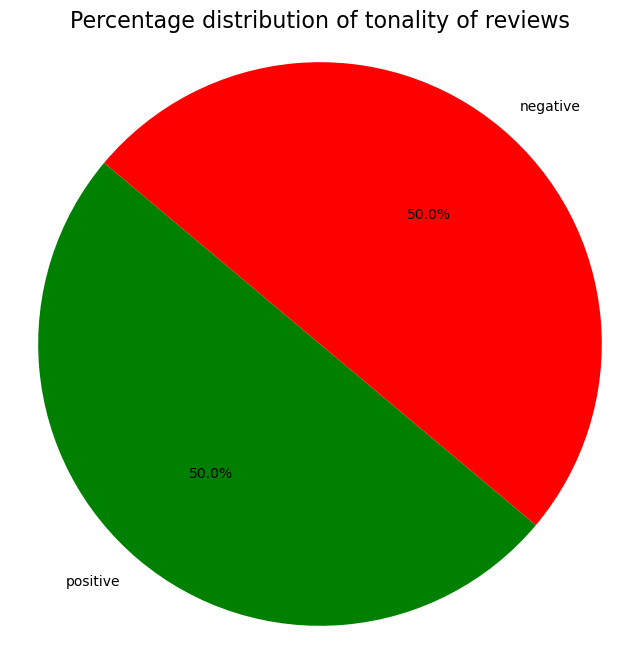

In [11]:
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['green','red'])
plt.title('Percentage distribution of tonality of reviews', fontsize=16)
plt.axis('equal')
plt.show()

The absence of class imbalance is an advantage for this dataset, as we do not need to apply special balancing methods at the modeling stages, which simplifies the process and provides a more reliable model estimate.

## Analysis of the length of reviews

In [12]:
# Add a column with the number of characters
df['review_length_chars'] = df['review'].apply(len)

# Add a column with the number of words
df['review_length_words'] = df['review'].apply(lambda x: len(x.split()))
print("DataFrame with added review length columns:")
print(df.head())
print("\nStatistics on review length (characters):")
print(df['review_length_chars'].describe())
print("\nStatistics on review length (words):")
print(df['review_length_words'].describe())

DataFrame with added review length columns:
                                              review sentiment  \
0  one of the other reviewers has mentioned that ...  positive   
1  a wonderful little production the filming tech...  positive   
2  i thought this was a wonderful way to spend ti...  positive   
3  basically there s a family where a little boy ...  negative   
4  petter mattei s love in the time of money is a...  positive   

   review_length_chars  review_length_words  
0                 1676                  313  
1                  940                  160  
2                  878                  167  
3                  686                  133  
4                 1243                  228  

Statistics on review length (characters):
count    50000.000000
mean      1248.336140
std        944.478143
min         30.000000
25%        668.000000
50%        925.000000
75%       1514.000000
max      13315.000000
Name: review_length_chars, dtype: float64

Statistics on review 

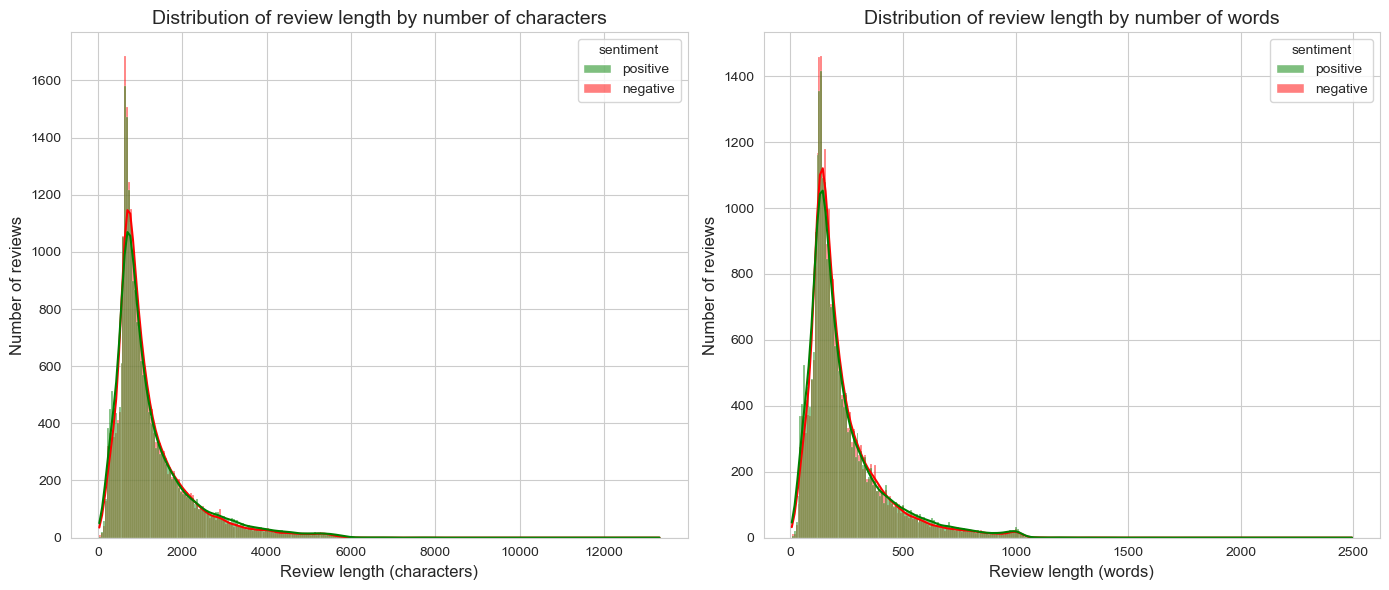

In [13]:
sns.set_style("whitegrid")

# Histogram of review length distribution (number of characters)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='review_length_chars', hue='sentiment', kde=True, palette={'positive': 'green', 'negative': 'red'})
plt.title('Distribution of review length by number of characters', fontsize=14)
plt.xlabel('Review length (characters)', fontsize=12)
plt.ylabel('Number of reviews', fontsize=12)

# Histogram of review length distribution (number of words)
plt.subplot(1, 2, 2) 
sns.histplot(data=df, x='review_length_words', hue='sentiment', kde=True, palette={'positive': 'green', 'negative': 'red'})
plt.title('Distribution of review length by number of words', fontsize=14)
plt.xlabel('Review length (words)', fontsize=12)
plt.ylabel('Number of reviews', fontsize=12)

plt.tight_layout()
plt.show()

The red (negative) and green (positive) length distribution curves almost completely overlap. This confirms that response length alone is not a strong predictor of tonality in this dataset.
Most reviews are concentrated in the range of ~1260 characters or ~240 words.

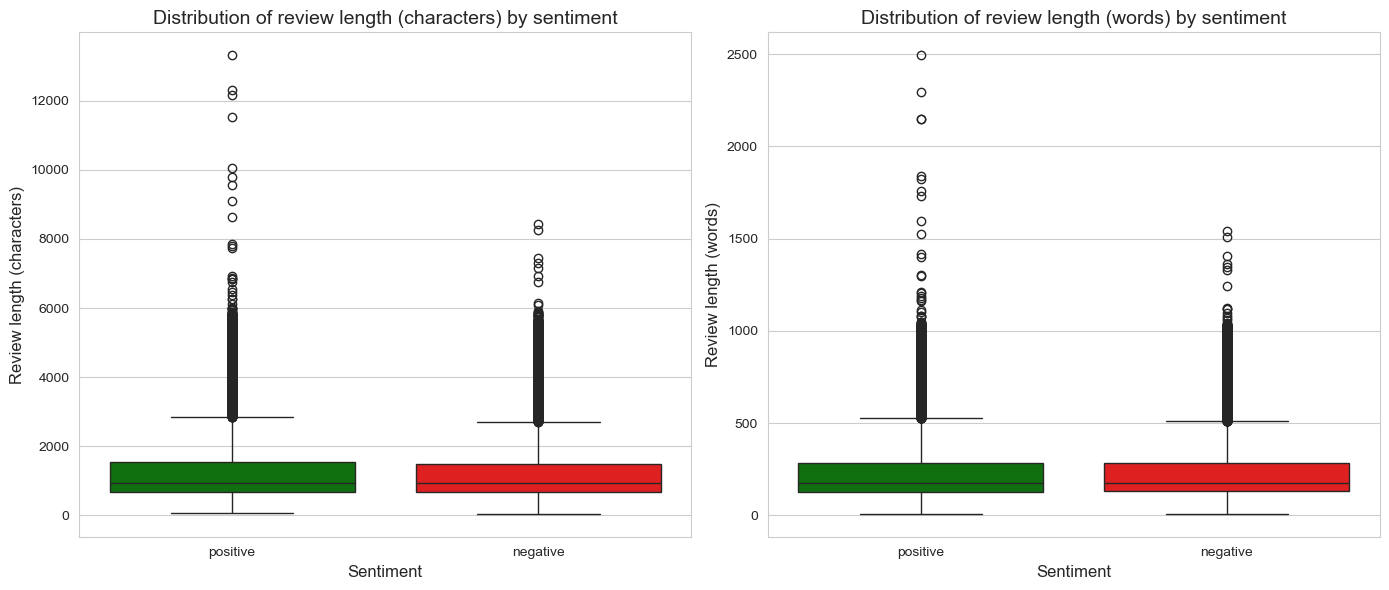

In [14]:
plt.figure(figsize=(14, 6))

# Boxplot of review length (characters) by sentiment
plt.subplot(1, 2, 1)
sns.boxplot(x='sentiment', y='review_length_chars', data=df, palette={'positive': 'green', 'negative': 'red'}, hue='sentiment', legend=False)
plt.title('Distribution of review length (characters) by sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Review length (characters)', fontsize=12)

# Boxplot of review length (words) by sentiment
plt.subplot(1, 2, 2)
sns.boxplot(x='sentiment', y='review_length_words', data=df, palette={'positive': 'green', 'negative': 'red'}, hue='sentiment', legend=False)
plt.title('Distribution of review length (words) by sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Review length (words)', fontsize=12)

plt.tight_layout()
plt.show()

The medians for positive and negative reviews are almost identical. The same applies to quartiles. It means that the central tendencies of length for both classes are the same.

Conclusions from the analysis of the length of reviews:
- Length is not a determining factor of tonality. There is no significant difference in the distribution of lengths between positive and negative reviews.
- The presence of long feedbacks. The maximum length of 13375 characters (or 2514 words) is significantly higher than the average. This should be taken into account when pre-processing the text.

## Word Clouds

In [15]:
# Get the list of English stop words from NLTK
stop_words_nltk = set(stopwords.words('english'))

# Also adding custom stop words because some words are uninformative
custom_stopwords = set(['movie', 'film', 'movies', 'films', 'would', 'really', 'one', 'get', 'like', 'see', 'just', 
                        'go', 'time','character', 'story', 'show', 'even', 'well', 'make','way', 'made'])
all_stopwords = stop_words_nltk.union(custom_stopwords).union(STOPWORDS) # Объединяем все стоп-слова

In [16]:
df['cleaned_review_with_stopwords'] = df['review']

print("Example of a basic cleaned review (with stop words):")
print(df['review'].iloc[0])
print(df['cleaned_review_with_stopwords'].iloc[0])

Example of a basic cleaned review (with stop words):
one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it 

In [17]:
# Function to remove stopwords from text
def remove_stopwords_from_text(text, stopwords_set):
    words = text.split()
    words = [word for word in words if word not in stopwords_set]
    return " ".join(words)

df['cleaned_review'] = df['cleaned_review_with_stopwords'].apply(
    lambda x: remove_stopwords_from_text(x, all_stopwords)
)

print("\nExample of a review without stop words (for clouds and unigram frequency):")
print(df['cleaned_review'].iloc[0])


Example of a review without stop words (for clouds and unigram frequency):
reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word trust faint hearted timid pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away say main appeal due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order away mannered middle class inmates turned pri

In [18]:
positive_reviews_text = " ".join(df[df['sentiment'] == 'positive']['cleaned_review'])
negative_reviews_text = " ".join(df[df['sentiment'] == 'negative']['cleaned_review'])

print(f"\nLength of combined text of positive reviews: {len(positive_reviews_text)} characters")
print(f"Length of combined text of negative reviews: {len(negative_reviews_text)} characters")


Length of combined text of positive reviews: 19213743 characters
Length of combined text of negative reviews: 18176622 characters


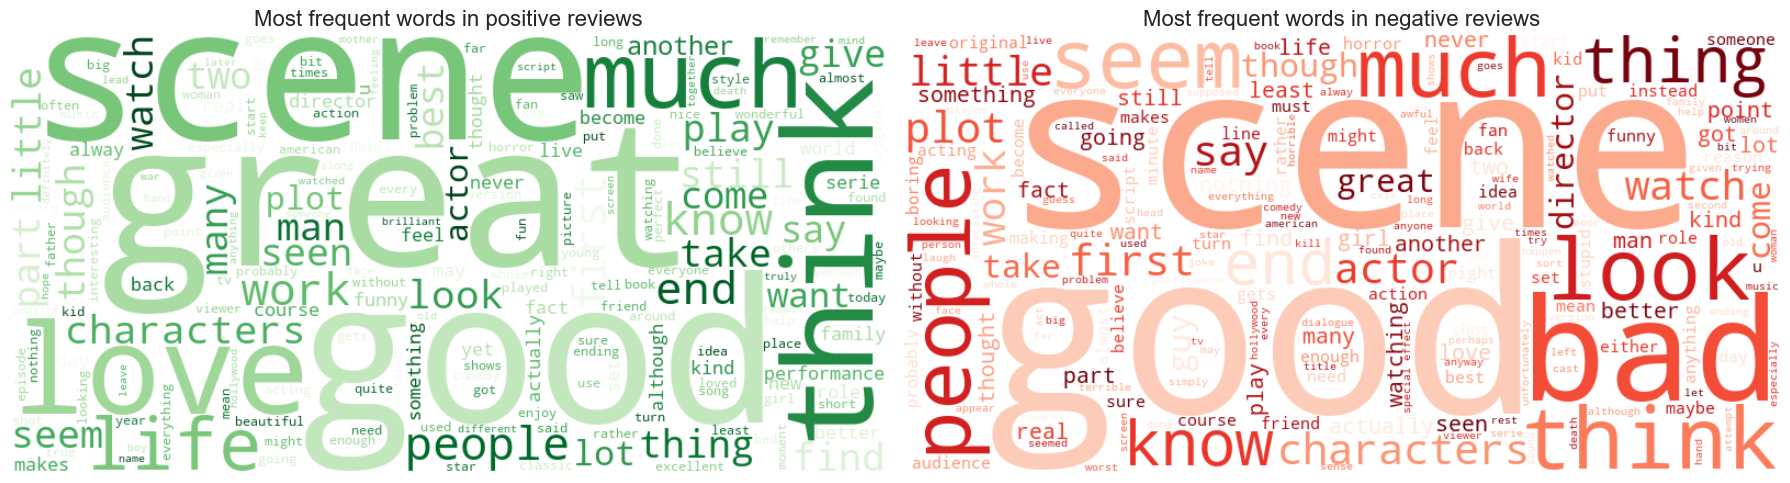

In [19]:
plt.figure(figsize=(18, 9))

# Word cloud for positive reviews
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
wordcloud_positive = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Greens',  # Color scheme for positive
                               min_font_size=10).generate(positive_reviews_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most frequent words in positive reviews', fontsize=16)
plt.axis('off') 

# Word cloud for negative reviews
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
wordcloud_negative = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Reds',  # Color scheme for negative
                               min_font_size=10).generate(negative_reviews_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most frequent words in negative reviews', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

Generated word clouds for positive and negative reviews after basic preprocessing. Visually confirmed the presence of words characteristic of each tonality and also found that some neutral words still occur very often in both types of reviews. Word clouds provide a quick, qualitative overview of vocabulary. They can be improved by adding neutral words to stop words vocabulary. The detection of frequently occurring neutral words allowed us to refine the list of stop words to focus on more emotionally colored vocabulary, although for N-grams I decided to keep stop words.

## Word frequency

In [20]:
positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']

# Count, fit and transform for positive reviews
vectorizer = CountVectorizer(min_df=5)
X_positive = vectorizer.fit_transform(positive_reviews)
positive_word_counts = X_positive.sum(axis=0)

# Count, fit and transform for negative reviews
vectorizer_neg = CountVectorizer(min_df=5)
X_negative = vectorizer_neg.fit_transform(negative_reviews)
negative_word_counts = X_negative.sum(axis=0)

In [21]:
# Get words and their frequencies for positive reviews
positive_words = []
for word, idx in vectorizer.vocabulary_.items():
    positive_words.append((word, positive_word_counts[0, idx]))
positive_words = sorted(positive_words, key=lambda x: x[1], reverse=True)

# Get words and their frequencies for negative reviews
negative_words = []
for word, idx in vectorizer_neg.vocabulary_.items():
    negative_words.append((word, negative_word_counts[0, idx]))
negative_words = sorted(negative_words, key=lambda x: x[1], reverse=True)

print("\nTop 20 most frequent words in positive reviews:")
print(positive_words[:20])

print("\nTop 20 most frequent words in negative reviews:")
print(negative_words[:20])


Top 20 most frequent words in positive reviews:
[('good', 15025), ('great', 12964), ('first', 9230), ('much', 9202), ('people', 8719), ('love', 8692), ('best', 8510), ('life', 8139), ('many', 7627), ('think', 7208), ('two', 7161), ('characters', 7103), ('man', 6762), ('seen', 6760), ('watch', 6727), ('little', 6462), ('still', 6425), ('never', 6336), ('know', 5769), ('years', 5381)]

Top 20 most frequent words in negative reviews:
[('good', 14728), ('bad', 14726), ('much', 10118), ('people', 9469), ('first', 8353), ('plot', 8214), ('acting', 8087), ('characters', 7353), ('watch', 7219), ('think', 7130), ('know', 6741), ('better', 6736), ('never', 6645), ('seen', 6616), ('two', 6384), ('little', 5973), ('say', 5909), ('nothing', 5883), ('something', 5855), ('many', 5819)]


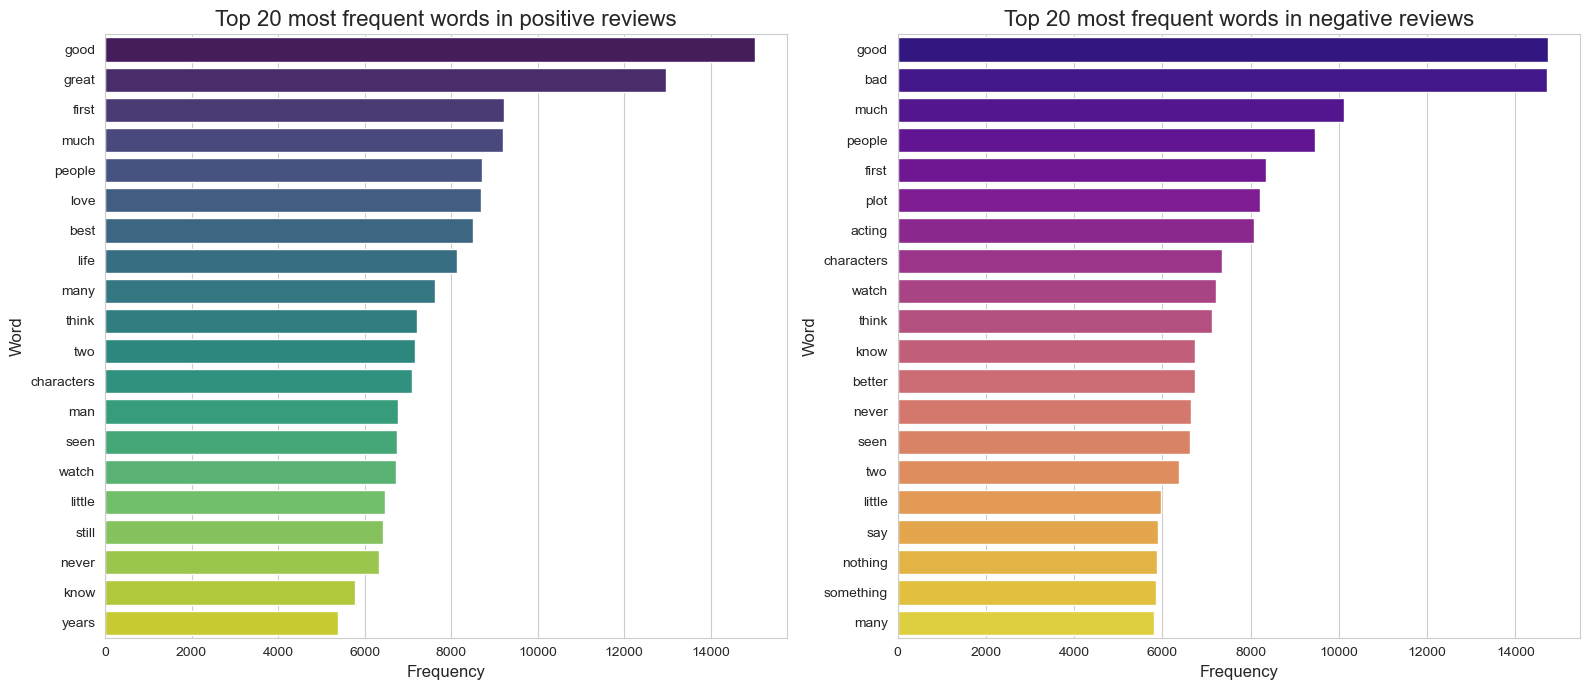

In [22]:
# Number of words to display
top_n = 20

# Prepare data for plotting
df_positive_words = pd.DataFrame(positive_words[:top_n], columns=['Word', 'Count'])
df_negative_words = pd.DataFrame(negative_words[:top_n], columns=['Word', 'Count'])

plt.figure(figsize=(16, 7))

# Plot for positive words
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Word', data=df_positive_words, palette='viridis', hue='Word', legend=False)
plt.title(f'Top {top_n} most frequent words in positive reviews', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)

# Plot for negative words
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Word', data=df_negative_words, palette='plasma', hue='Word', legend=False)
plt.title(f'Top {top_n} most frequent words in negative reviews', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)

plt.tight_layout()
plt.show()

## Bi-grams and Tri-grams

We build Bi-grams and Tri-grams for cleaned reviews with stopwords and without to check how it looks and understand importance of stopwords and possible logic constructions (like 'not good')

In [23]:
def get_top_ngrams(corpus, n, ngram_range=(2,2), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=5).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Separate reviews by sentiment
positive_reviews_text = df[df['sentiment'] == 'positive']['cleaned_review_with_stopwords']
negative_reviews_text = df[df['sentiment'] == 'negative']['cleaned_review_with_stopwords']

In [24]:
print("\n--- Bi-grams ---")
# Top Bi-grams for positive reviews
positive_bigrams = get_top_ngrams(positive_reviews_text, n=2, ngram_range=(2, 2))
print("\nTop 20 Bi-grams in positive reviews with stopwords:")
print(positive_bigrams)

# Top Bi-grams for negative reviews
negative_bigrams = get_top_ngrams(negative_reviews_text, n=2, ngram_range=(2, 2))
print("\nTop 20 Bi-grams in negative reviews with stopwords:")
print(negative_bigrams)


--- Bi-grams ---

Top 20 Bi-grams in positive reviews with stopwords:
[('of the', 41670), ('in the', 25907), ('the film', 14716), ('and the', 14457), ('this movie', 13535), ('to the', 12832), ('it is', 11555), ('this film', 10939), ('the movie', 10449), ('this is', 10153), ('to be', 10131), ('one of', 9623), ('on the', 9114), ('with the', 8257), ('for the', 8065), ('it was', 7916), ('at the', 7389), ('is the', 7278), ('as the', 7049), ('if you', 6695)]

Top 20 Bi-grams in negative reviews with stopwords:
[('of the', 35714), ('in the', 24611), ('this movie', 18024), ('the movie', 13529), ('to be', 13360), ('and the', 12297), ('the film', 12233), ('to the', 10919), ('this film', 10919), ('it was', 9226), ('on the', 8906), ('this is', 8503), ('it is', 8370), ('for the', 7890), ('with the', 7524), ('if you', 7365), ('one of', 6633), ('is the', 6494), ('in this', 6480), ('at the', 6254)]


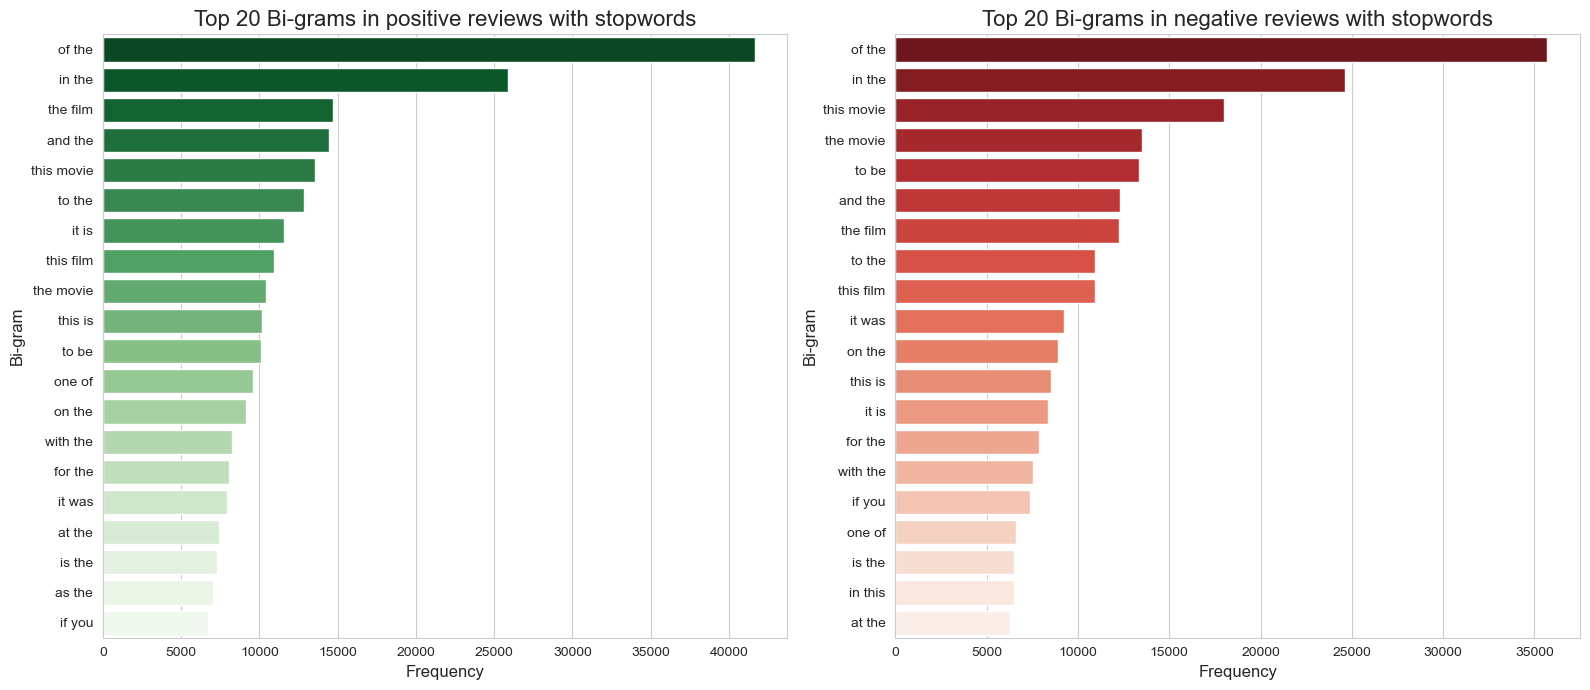

In [25]:
# Visualization of Bi-grams
df_positive_bigrams = pd.DataFrame(positive_bigrams, columns=['Ngram', 'Count'])
df_negative_bigrams = pd.DataFrame(negative_bigrams, columns=['Ngram', 'Count'])

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Ngram', data=df_positive_bigrams, palette='Greens_r', hue='Ngram', legend=False)
plt.title(f'Top {len(positive_bigrams)} Bi-grams in positive reviews with stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bi-gram', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Ngram', data=df_negative_bigrams, palette='Reds_r', hue='Ngram', legend=False)
plt.title(f'Top {len(negative_bigrams)} Bi-grams in negative reviews with stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bi-gram', fontsize=12)

plt.tight_layout()
plt.show()

In [26]:
print("\n--- Tri-grams ---")
# Top Tri-grams for positive reviews
positive_trigrams = get_top_ngrams(positive_reviews_text, n=3, ngram_range=(3, 3))
print("\nTop 20 Tri-grams in positive reviews with stopwords:")
print(positive_trigrams)

# Top Tri-grams for negative reviews
negative_trigrams = get_top_ngrams(negative_reviews_text, n=3, ngram_range=(3, 3))
print("\nTop 20 Tri-grams in negative reviews with stopwords:")
print(negative_trigrams)


--- Tri-grams ---

Top 20 Tri-grams in positive reviews with stopwords:
[('one of the', 5827), ('of the film', 2786), ('is one of', 2383), ('this movie is', 2273), ('the film is', 2116), ('some of the', 2048), ('this film is', 1816), ('of the movie', 1760), ('of the best', 1701), ('in the film', 1659), ('as well as', 1478), ('in this film', 1413), ('the movie is', 1410), ('in this movie', 1321), ('the fact that', 1308), ('in the movie', 1303), ('of the most', 1301), ('at the end', 1225), ('this is the', 1148), ('the story is', 1093)]

Top 20 Tri-grams in negative reviews with stopwords:
[('one of the', 3997), ('this movie is', 3018), ('of the movie', 2581), ('of the film', 2393), ('in this movie', 1881), ('in the movie', 1787), ('some of the', 1731), ('this film is', 1704), ('this movie was', 1689), ('the movie is', 1679), ('the film is', 1579), ('the fact that', 1552), ('in the film', 1521), ('the rest of', 1516), ('in this film', 1360), ('most of the', 1349), ('supposed to be', 1265

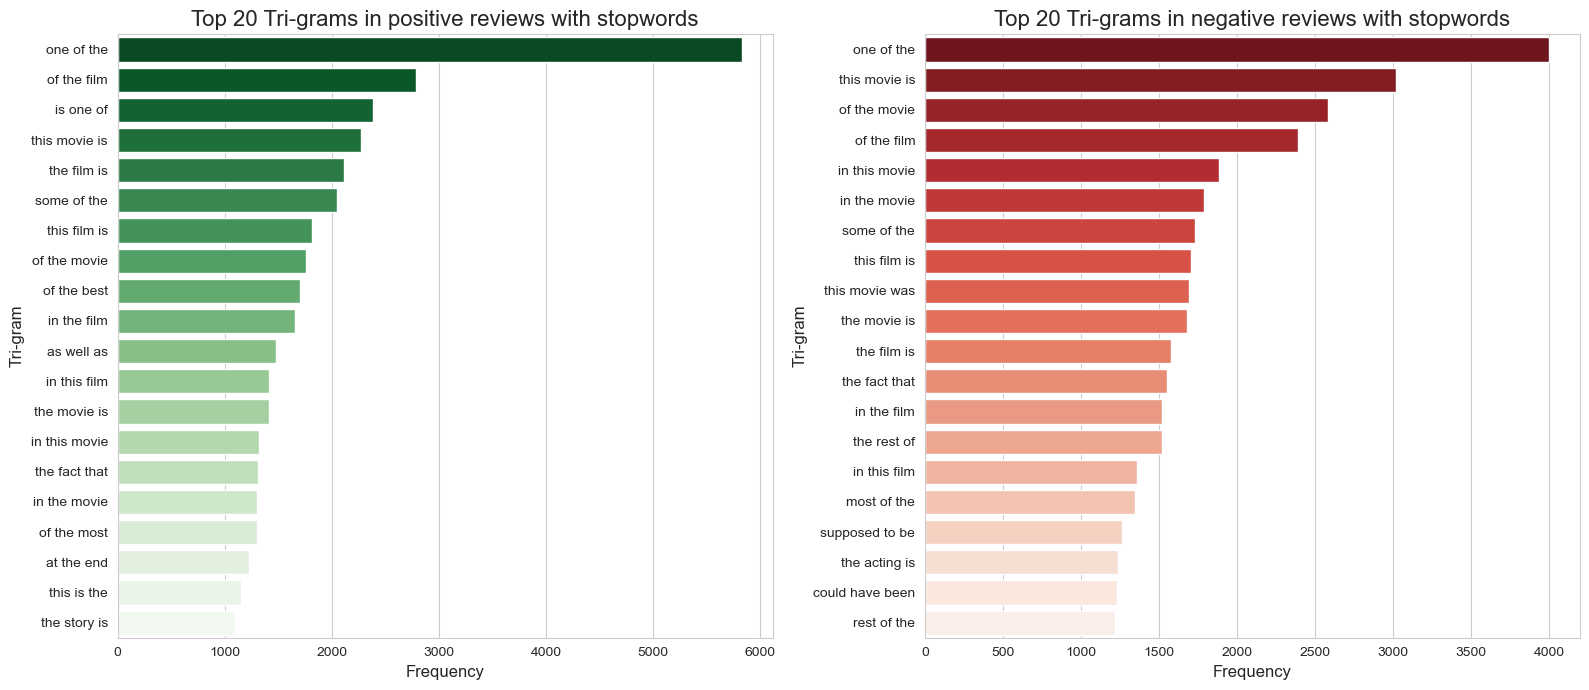

In [27]:
# Visualization of Tri-grams
df_positive_trigrams = pd.DataFrame(positive_trigrams, columns=['Ngram', 'Count'])
df_negative_trigrams = pd.DataFrame(negative_trigrams, columns=['Ngram', 'Count'])

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Ngram', data=df_positive_trigrams, palette='Greens_r', hue='Ngram', legend=False)
plt.title(f'Top {len(positive_trigrams)} Tri-grams in positive reviews with stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Tri-gram', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Ngram', data=df_negative_trigrams, palette='Reds_r', hue='Ngram', legend=False)
plt.title(f'Top {len(negative_trigrams)} Tri-grams in negative reviews with stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Tri-gram', fontsize=12)

plt.tight_layout()
plt.show()


--- Bi-grams ---

Top 20 Bi-grams in positive reviews without stopwords:
[('new york', 855), ('special effects', 810), ('real life', 761), ('years ago', 741), ('year old', 686), ('sci fi', 623), ('low budget', 594), ('pretty good', 583), ('years later', 566), ('high school', 557), ('first saw', 542), ('highly recommend', 503), ('much better', 489), ('black white', 477), ('many people', 473), ('worth watching', 454), ('never seen', 435), ('good job', 433), ('supporting cast', 426), ('pretty much', 417)]

Top 20 Bi-grams in negative reviews without stopwords:
[('special effects', 1449), ('low budget', 1230), ('much better', 1010), ('worst seen', 980), ('year old', 915), ('sci fi', 770), ('bad acting', 702), ('pretty much', 683), ('high school', 607), ('pretty good', 527), ('years ago', 515), ('whole thing', 496), ('real life', 480), ('new york', 462), ('good thing', 457), ('camera work', 448), ('acting bad', 439), ('waste money', 433), ('bad bad', 427), ('never seen', 425)]


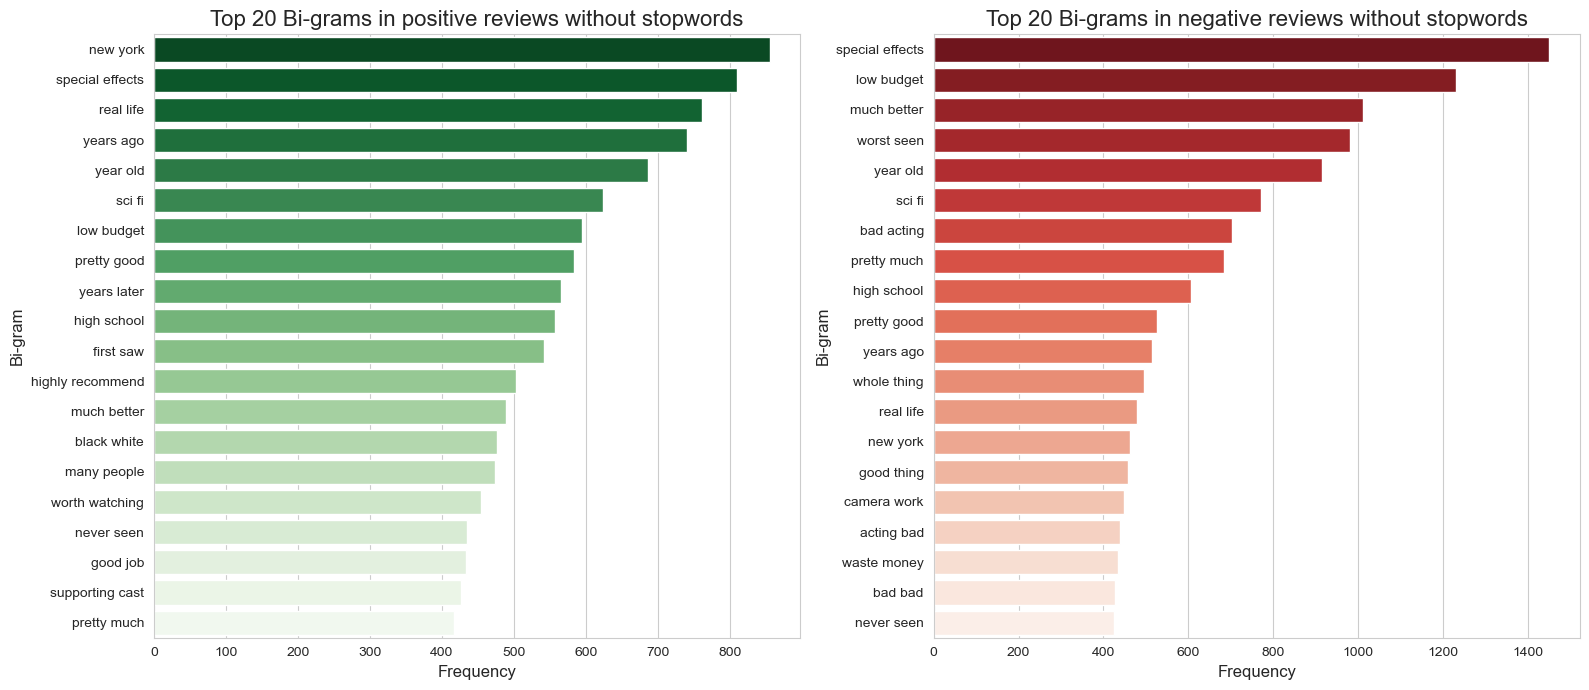

In [28]:
print("\n--- Bi-grams ---")
# Top Bi-grams for positive reviews
positive_bigrams = get_top_ngrams(positive_reviews, n=2, ngram_range=(2, 2))
print("\nTop 20 Bi-grams in positive reviews without stopwords:")
print(positive_bigrams)

# Top Bi-grams for negative reviews
negative_bigrams = get_top_ngrams(negative_reviews, n=2, ngram_range=(2, 2))
print("\nTop 20 Bi-grams in negative reviews without stopwords:")
print(negative_bigrams)

# Visualization of Bi-grams
df_positive_bigrams = pd.DataFrame(positive_bigrams, columns=['Ngram', 'Count'])
df_negative_bigrams = pd.DataFrame(negative_bigrams, columns=['Ngram', 'Count'])

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Ngram', data=df_positive_bigrams, palette='Greens_r', hue='Ngram', legend=False)
plt.title(f'Top {len(positive_bigrams)} Bi-grams in positive reviews without stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bi-gram', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Ngram', data=df_negative_bigrams, palette='Reds_r', hue='Ngram', legend=False)
plt.title(f'Top {len(negative_bigrams)} Bi-grams in negative reviews without stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bi-gram', fontsize=12)

plt.tight_layout()
plt.show()


--- Tri-grams ---

Top 20 Tri-grams in positive reviews without stopwords:
[('new york city', 195), ('world war ii', 167), ('many years ago', 73), ('second world war', 68), ('two main characters', 67), ('tour de force', 62), ('breath fresh air', 53), ('year old boy', 53), ('sit back enjoy', 52), ('definitely worth seeing', 52), ('highly recommend anyone', 51), ('seen many times', 51), ('saw years ago', 50), ('tale two sisters', 49), ('good old fashioned', 47), ('low budget horror', 46), ('never say never', 46), ('philip seymour hoffman', 43), ('texas chainsaw massacre', 43), ('robert de niro', 43)]

Top 20 Tri-grams in negative reviews without stopwords:
[('sci fi channel', 138), ('bad acting bad', 137), ('low budget horror', 94), ('mystery science theater', 92), ('bad bad bad', 84), ('blah blah blah', 84), ('new york city', 82), ('first half hour', 79), ('plan outer space', 73), ('two main characters', 72), ('world war ii', 64), ('blair witch project', 62), ('first five minutes', 60)

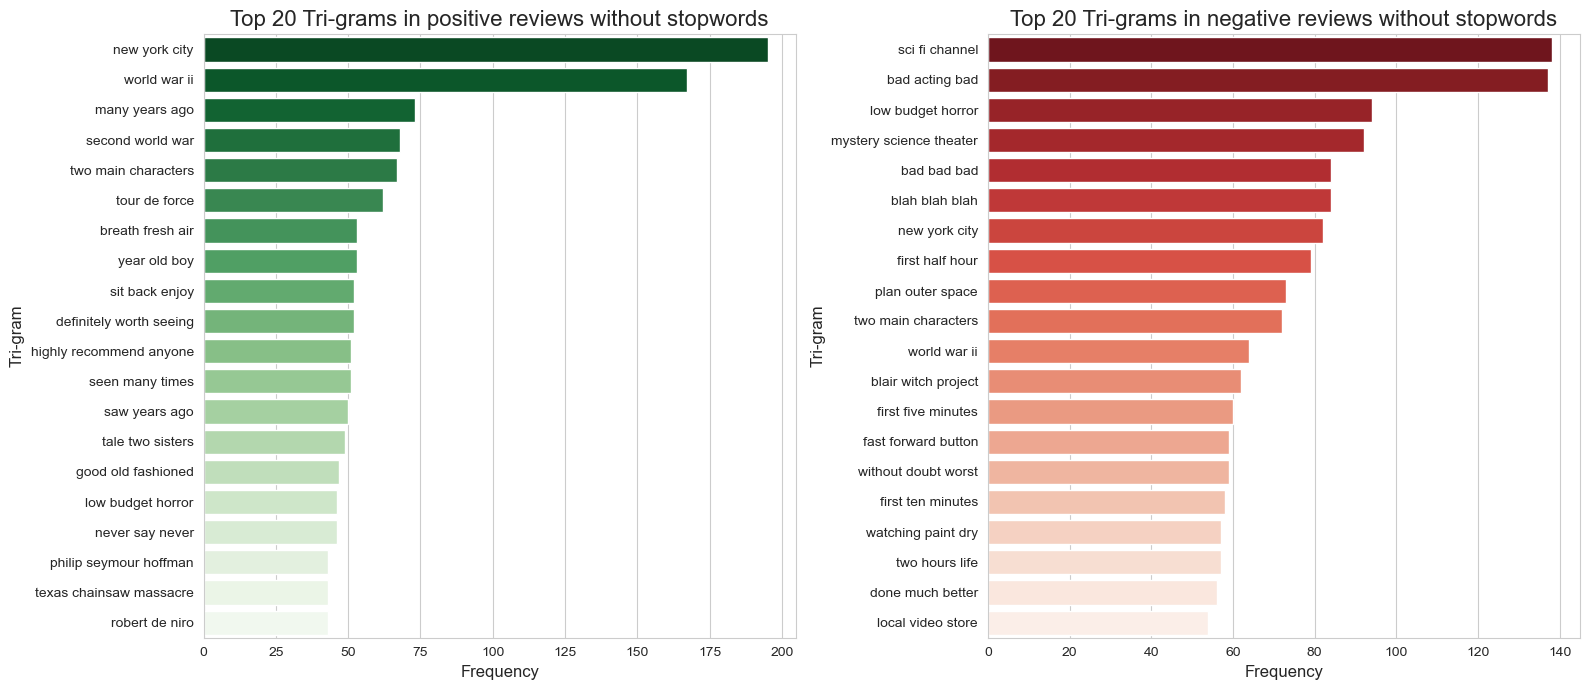

In [29]:
print("\n--- Tri-grams ---")
# Top Tri-grams for positive reviews
positive_trigrams = get_top_ngrams(positive_reviews, n=3, ngram_range=(3, 3))
print("\nTop 20 Tri-grams in positive reviews without stopwords:")
print(positive_trigrams)

# Top Tri-grams for negative reviews
negative_trigrams = get_top_ngrams(negative_reviews, n=3, ngram_range=(3, 3))
print("\nTop 20 Tri-grams in negative reviews without stopwords:")
print(negative_trigrams)

# Visualization of Tri-grams
df_positive_trigrams = pd.DataFrame(positive_trigrams, columns=['Ngram', 'Count'])
df_negative_trigrams = pd.DataFrame(negative_trigrams, columns=['Ngram', 'Count'])

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Ngram', data=df_positive_trigrams, palette='Greens_r', hue='Ngram', legend=False)
plt.title(f'Top {len(positive_trigrams)} Tri-grams in positive reviews without stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Tri-gram', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Ngram', data=df_negative_trigrams, palette='Reds_r', hue='Ngram', legend=False)
plt.title(f'Top {len(negative_trigrams)} Tri-grams in negative reviews without stopwords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Tri-gram', fontsize=12)

plt.tight_layout()
plt.show()

We quantitatively determined the top 20 most frequent unigrams, bigrams, and trigrams for each sentiment class (positive and negative) using CountVectorizer. Our analysis confirmed that terms such as 'good', 'great', 'love', and 'best' were characteristic of positive sentiment, while 'bad', 'plot', 'acting', and 'nothing' indicated negative sentiment. We also observed a high frequency of neutral words like 'first', 'much', 'people', 'think', 'know', 'seen', 'watch', 'two', and 'many', which appeared across both classes. Notably, the word 'good' was frequent in both positive and negative reviews, often appearing in phrases like 'not good.'

Although N-grams including stop words are not highly informative for direct human interpretation, we made a strategic decision to preserve them for TF-IDF vectorization. This approach is beneficial because TF-IDF inherently reduces the weight of commonly occurring terms across the corpus, and removing stop words prematurely can lead to the loss of valuable contextual information (for instance, the critical distinction in 'not good').

# Step 3: Text Preprocessing

In [30]:
lemmatizer = WordNetLemmatizer()

# We perform full text preprocessing for sentiment analysis. Some steps were already included in the base cleaning:

def preprocess_text(text):
    
    text = str(text)

    # 1. Lowercasing
    text = text.lower()

    # 2. Removal of HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # 3. Removal of URLs (start with http/https/www)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # 4. Removal of punctuation, numbers, and special characters, replacement with spaces
    # [^a-z\s] means "anything that is not a lowercase letter or a space"
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 5. Normalization of multiple spaces to a single one and removal of leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Lemmatization
    # First tokenize, then lemmatize, then rejoin into a string
    words = text.split()  # Simple tokenization by spaces
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(lemmatized_words)

    return text

In [31]:
print("Applying preprocessing to reviews.")
df['processed_review'] = df['review'].apply(preprocess_text)
print("Preprocessing completed.")

Applying preprocessing to reviews.
Preprocessing completed.


# Step 4: Text Vectorization

In [32]:
print("First 5 rows of preprocessed reviews:")
print(df[['review', 'processed_review', 'sentiment']].head())

First 5 rows of preprocessed reviews:
                                              review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production the filming tech...   
2  i thought this was a wonderful way to spend ti...   
3  basically there s a family where a little boy ...   
4  petter mattei s love in the time of money is a...   

                                    processed_review sentiment  
0  one of the other reviewer ha mentioned that af...  positive  
1  a wonderful little production the filming tech...  positive  
2  i thought this wa a wonderful way to spend tim...  positive  
3  basically there s a family where a little boy ...  negative  
4  petter mattei s love in the time of money is a...  positive  


In [33]:
X = df['processed_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Training TfidfVectorizer on training data and transforming it
tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensionality of training data after TF-IDF: {X_train_tfidf.shape}")
print(f"Dimensionality of test data after TF-IDF: {X_test_tfidf.shape}")

Dimensionality of training data after TF-IDF: (40000, 20000)
Dimensionality of test data after TF-IDF: (10000, 20000)


In [35]:
print("\nFirst 20 features from TF-IDF vocabulary:")
print(tfidf_vectorizer.get_feature_names_out()[:20])
print("\nLast 20 features from TF-IDF vocabulary:")
print(tfidf_vectorizer.get_feature_names_out()[-20:])


First 20 features from TF-IDF vocabulary:
['aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'ability' 'ability to'
 'able' 'able to' 'aboard' 'abomination' 'abortion' 'abound' 'about'
 'about all' 'about an' 'about and' 'about any' 'about anything'
 'about being']

Last 20 features from TF-IDF vocabulary:
['yourself' 'yourself and' 'yourself favor' 'yourself the' 'yourself to'
 'youth' 'youthful' 'youtube' 'yr' 'zane' 'zany' 'zellweger' 'zero' 'zeta'
 'zoey' 'zombi' 'zombie' 'zombie movie' 'zone' 'zoom']


## Step 5: Model Building and Training

In [36]:
# Conversion of target variable y to numeric format
y_train_encoded = y_train.map({'negative': 0, 'positive': 1})
y_test_encoded = y_test.map({'negative': 0, 'positive': 1})


--- Training and Evaluation: Logistic Regression ---

Accuracy (Logistic Regression): 0.9043

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5000
    positive       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Confusion Matrix (Logistic Regression):
 [[4499  501]
 [ 456 4544]]


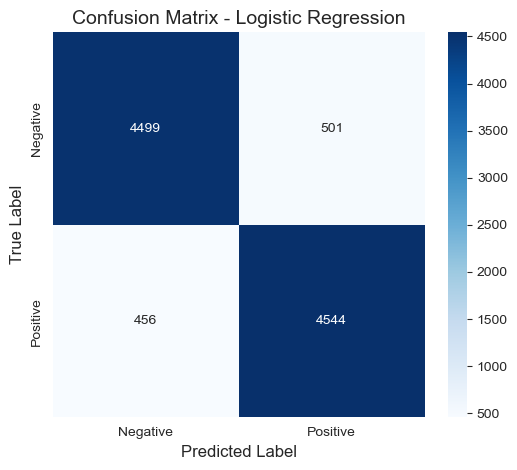

In [37]:
print("\n--- Training and Evaluation: Logistic Regression ---")

log_reg_model = LogisticRegression(solver='liblinear', random_state=42)
log_reg_model.fit(X_train_tfidf, y_train_encoded)

y_pred_log_reg = log_reg_model.predict(X_test_tfidf)

# Evaluate performance
print("\nAccuracy (Logistic Regression):", accuracy_score(y_test_encoded, y_pred_log_reg))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test_encoded, y_pred_log_reg, target_names=['negative', 'positive']))

# Confusion matrix
conf_matrix_log_reg = confusion_matrix(y_test_encoded, y_pred_log_reg)
print("\nConfusion Matrix (Logistic Regression):\n", conf_matrix_log_reg)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


--- Training and Evaluation: Multinomial Naive Bayes ---

Accuracy (Multinomial Naive Bayes): 0.8768

Classification Report (Multinomial Naive Bayes):
               precision    recall  f1-score   support

    negative       0.88      0.87      0.88      5000
    positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix (Multinomial Naive Bayes):
 [[4333  667]
 [ 565 4435]]


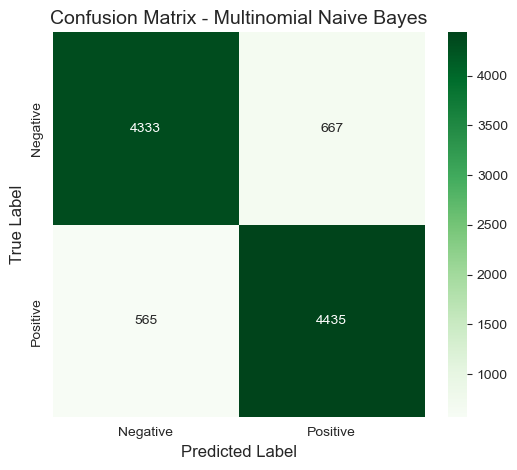

In [38]:
print("\n--- Training and Evaluation: Multinomial Naive Bayes ---")

# Initialize Multinomial Naive Bayes model
mnb_model = MultinomialNB(alpha=1.0)
mnb_model.fit(X_train_tfidf, y_train_encoded)

y_pred_mnb = mnb_model.predict(X_test_tfidf)

# Evaluate performance
print("\nAccuracy (Multinomial Naive Bayes):", accuracy_score(y_test_encoded, y_pred_mnb))
print("\nClassification Report (Multinomial Naive Bayes):\n", classification_report(y_test_encoded, y_pred_mnb, target_names=['negative', 'positive']))

# Confusion matrix
conf_matrix_mnb = confusion_matrix(y_test_encoded, y_pred_mnb)
print("\nConfusion Matrix (Multinomial Naive Bayes):\n", conf_matrix_mnb)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_mnb, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Multinomial Naive Bayes', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [39]:
'''print("\n--- Training and Evaluation: Support Vector Machine (SVC) ---")

# Initialize SVC model
svc_model = SVC(kernel='linear', random_state=42, C=1.0)

print("Starting SVC training.")
svc_model.fit(X_train_tfidf, y_train_encoded)
print("SVC training completed.")

y_pred_svc = svc_model.predict(X_test_tfidf)

# Evaluate performance
print("\nAccuracy (SVC):", accuracy_score(y_test_encoded, y_pred_svc))
print("\nClassification Report (SVC):\n", classification_report(y_test_encoded, y_pred_svc, target_names=['negative', 'positive']))

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test_encoded, y_pred_svc)
print("\nConfusion Matrix (SVC):\n", conf_matrix_svc)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Support Vector Machine (SVC)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()'''

'print("\n--- Training and Evaluation: Support Vector Machine (SVC) ---")\n\n# Initialize SVC model\nsvc_model = SVC(kernel=\'linear\', random_state=42, C=1.0)\n\nprint("Starting SVC training.")\nsvc_model.fit(X_train_tfidf, y_train_encoded)\nprint("SVC training completed.")\n\ny_pred_svc = svc_model.predict(X_test_tfidf)\n\n# Evaluate performance\nprint("\nAccuracy (SVC):", accuracy_score(y_test_encoded, y_pred_svc))\nprint("\nClassification Report (SVC):\n", classification_report(y_test_encoded, y_pred_svc, target_names=[\'negative\', \'positive\']))\n\n# Confusion matrix\nconf_matrix_svc = confusion_matrix(y_test_encoded, y_pred_svc)\nprint("\nConfusion Matrix (SVC):\n", conf_matrix_svc)\n\n# Visualize confusion matrix\nplt.figure(figsize=(6, 5))\nsns.heatmap(conf_matrix_svc, annot=True, fmt=\'d\', cmap=\'Purples\', xticklabels=[\'Negative\', \'Positive\'], yticklabels=[\'Negative\', \'Positive\'])\nplt.title(\'Confusion Matrix - Support Vector Machine (SVC)\', fontsize=14)\nplt.xla

Code for SVC model is commented to avoid random execution. The results of this model have been attached below.
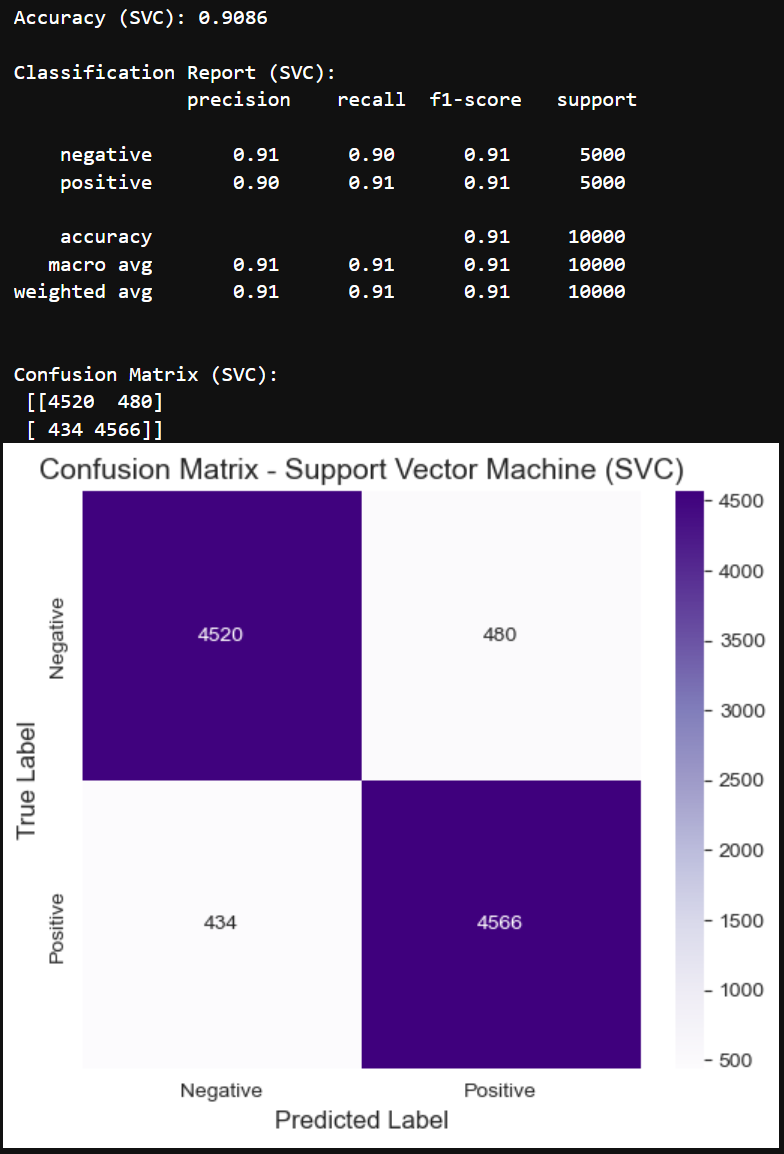

All three models showed very good results for the task of tonality analysis on this dataset, significantly exceeding random guessing (50%).
SVC showed the highest performance, slightly superior to Logistic Regression. Multinomial Naive Bayes is also good, but inferior to the first two.
Despite that SVC has slightly better scores, it was decided to pick Logistic Regression for this project because Logistic Regression works significantly faster compared to SVC.
In next step we will try to check if it's possible to improve our results.

## Step 6: Model Evaluation and Improvement

In [40]:
print("\n--- Analysis of Important Features (Logistic Regression) ---")

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get model coefficients
coefficients = log_reg_model.coef_[0]

feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort in descending order for most positive (large positive coefficient)
top_positive_features = feature_importance.sort_values(by='coefficient', ascending=False).head(20)

# Sort in ascending order for most negative (large negative coefficient)
top_negative_features = feature_importance.sort_values(by='coefficient', ascending=True).head(20)

print("\nTop 20 features most associated with POSITIVE sentiment:")
print(top_positive_features)

print("\nTop 20 features most associated with NEGATIVE sentiment:")
print(top_negative_features)


--- Analysis of Important Features (Logistic Regression) ---

Top 20 features most associated with POSITIVE sentiment:
          feature  coefficient
6620        great     7.899487
5161    excellent     6.358176
12361     perfect     5.186809
567       amazing     4.711613
19602   wonderful     4.689028
6187          fun     4.263903
15916    the best     4.206764
2427    brilliant     3.991674
7346    hilarious     3.968749
17842       today     3.850029
9836        loved     3.805967
2118         best     3.731192
4894      enjoyed     3.587665
18983        well     3.543599
15310      superb     3.462845
5448     favorite     3.442099
3983   definitely     3.375443
4889    enjoyable     3.356454
7341       highly     3.332339
15051       still     3.281819

Top 20 features most associated with NEGATIVE sentiment:
             feature  coefficient
1738             bad    -8.561517
19693          worst    -8.238985
1694           awful    -7.415418
2325          boring    -6.477638
1

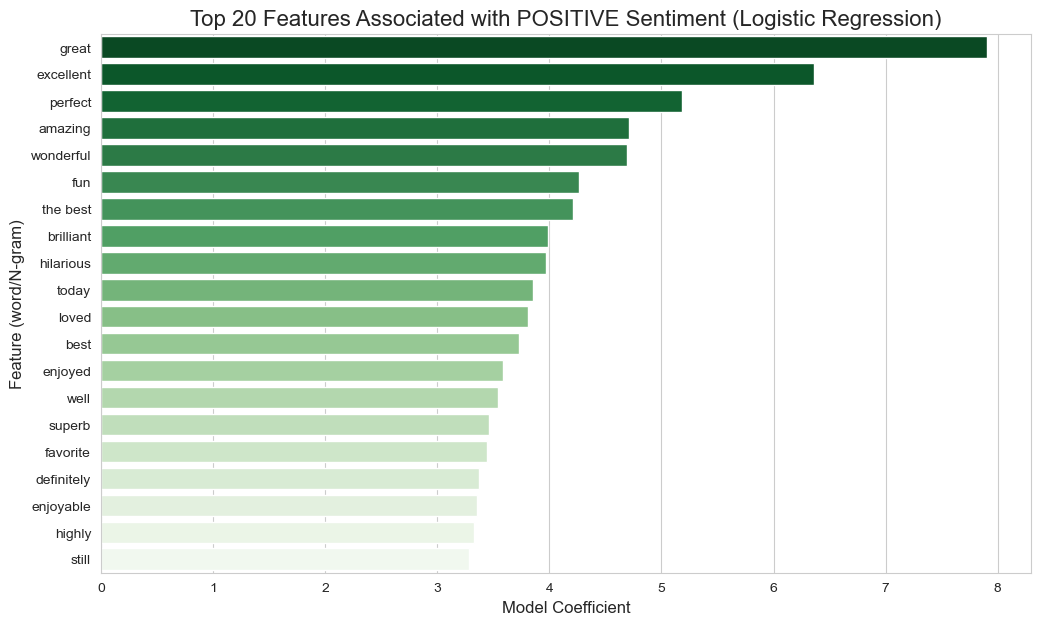

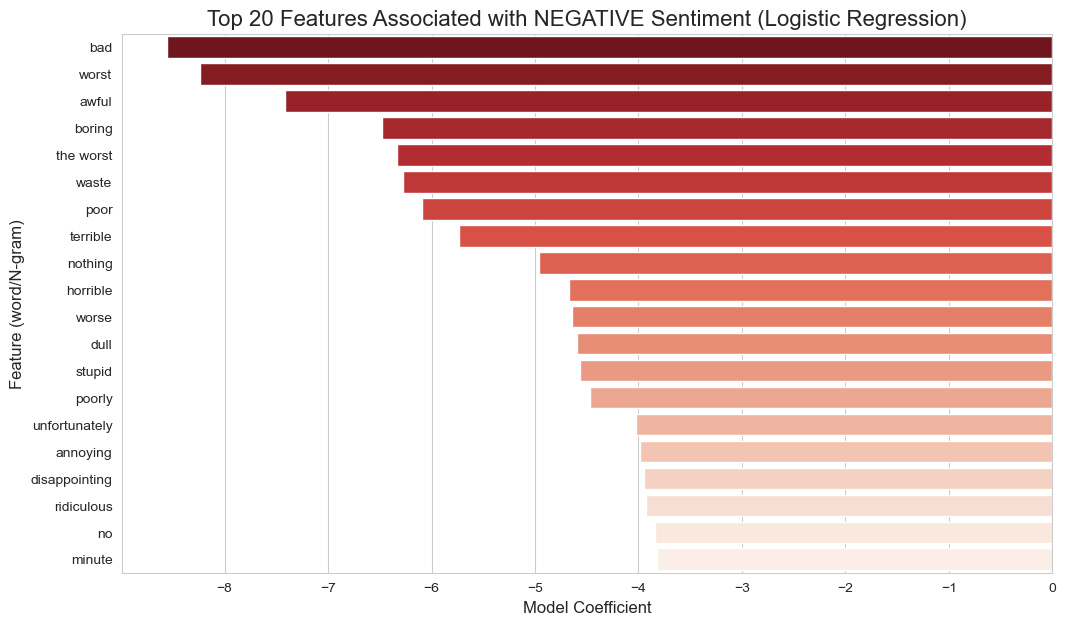

In [41]:
# Visualize top positive features
plt.figure(figsize=(12, 7))
sns.barplot(x='coefficient', y='feature', data=top_positive_features, palette='Greens_r', hue='feature', legend=False)
plt.title('Top 20 Features Associated with POSITIVE Sentiment (Logistic Regression)', fontsize=16)
plt.xlabel('Model Coefficient', fontsize=12)
plt.ylabel('Feature (word/N-gram)', fontsize=12)
plt.show()

# Visualize top negative features
plt.figure(figsize=(12, 7))
sns.barplot(x='coefficient', y='feature', data=top_negative_features, palette='Reds_r', hue='feature', legend=False)
plt.title('Top 20 Features Associated with NEGATIVE Sentiment (Logistic Regression)', fontsize=16)
plt.xlabel('Model Coefficient', fontsize=12)
plt.ylabel('Feature (word/N-gram)', fontsize=12)
plt.show()

In [42]:
print("\n--- Hyperparameter Optimization using GridSearchCV ---")

# Create a pipeline that includes vectorization and the model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('log_reg', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'tfidf__max_features': [10000, 20000, 30000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Uni-grams, or Uni+Bi-grams
    'log_reg__C': [2.0, 1.0, 3.0]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1)

# Run grid search on training data
print("Starting GridSearchCV.")
grid_search.fit(X_train, y_train_encoded)

print("\nBest parameters found by GridSearchCV:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


--- Hyperparameter Optimization using GridSearchCV ---
Starting GridSearchCV.
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters found by GridSearchCV: {'log_reg__C': 3.0, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}
Best cross-validation accuracy: 0.9030999886291592



Accuracy of the best model (after tuning): 0.9118
Classification Report of the best model:
               precision    recall  f1-score   support

    negative       0.92      0.91      0.91      5000
    positive       0.91      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000


Confusion Matrix of the best model:
 [[4529  471]
 [ 411 4589]]


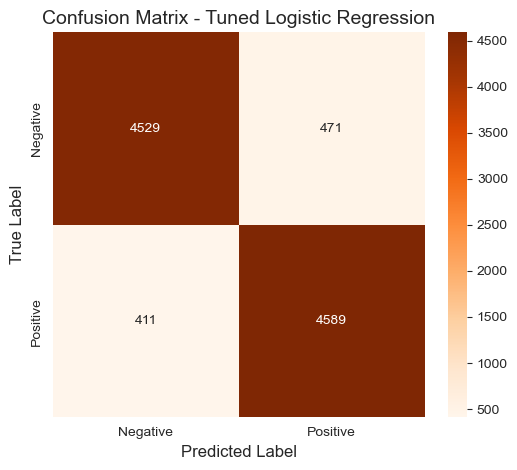

In [43]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\nAccuracy of the best model (after tuning):", accuracy_score(y_test_encoded, y_pred_tuned))
print("Classification Report of the best model:\n", classification_report(y_test_encoded, y_pred_tuned, target_names=['negative', 'positive']))

conf_matrix_tuned = confusion_matrix(y_test_encoded, y_pred_tuned)
print("\nConfusion Matrix of the best model:\n", conf_matrix_tuned)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Oranges', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Tuned Logistic Regression', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## Cross-validation


--- Performing Cross-validation for Logistic Regression ---

Лучшие параметры, полученные из grid_search.best_params_: {'log_reg__C': 3.0, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}

Parameters for TfidfVectorizer: {'max_features': 30000, 'ngram_range': (1, 2)}
Parameters for LogisticRegression: {'C': 3.0}

--- Performing Cross-validation for Logistic Regression with best parameters ---
Starting 5-fold cross-validation.

Cross-validation results (accuracy on each fold):
[0.9091 0.9081 0.907  0.9106 0.912 ]
Mean cross-validation accuracy: 0.9094
Standard deviation of accuracy: 0.0018


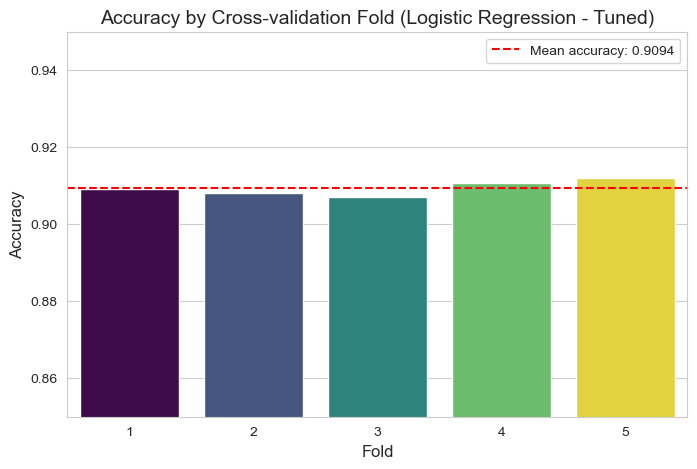

In [44]:
print("\n--- Performing Cross-validation for Logistic Regression ---")

best_params = grid_search.best_params_
print("\nЛучшие параметры, полученные из grid_search.best_params_:", best_params)

# Extract parameters for TfidfVectorizer and LogisticRegression
tfidf_params = {k.replace('tfidf__', ''): v for k, v in best_params.items() if k.startswith('tfidf__')}
log_reg_params = {k.replace('log_reg__', ''): v for k, v in best_params.items() if k.startswith('log_reg__')}

print("\nParameters for TfidfVectorizer:", tfidf_params)
print("Parameters for LogisticRegression:", log_reg_params)

print("\n--- Performing Cross-validation for Logistic Regression with best parameters ---")

# Encode the target variable y for cross-validation
y_encoded_full = df['sentiment'].map({'negative': 0, 'positive': 1})

# Create a pipeline using automatically obtained best parameters
tuned_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)), 
    ('log_reg', LogisticRegression(**log_reg_params, solver='liblinear', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
print("Starting 5-fold cross-validation.")
cv_scores = cross_val_score(tuned_pipeline, df['processed_review'], y_encoded_full, cv=cv, scoring='accuracy')

print("\nCross-validation results (accuracy on each fold):")
print(cv_scores)
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of accuracy: {np.std(cv_scores):.4f}")

# Can also plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(1, len(cv_scores) + 1)), y=cv_scores, palette='viridis', hue=list(range(1, len(cv_scores) + 1)), legend=False)
plt.axhline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean accuracy: {np.mean(cv_scores):.4f}')
plt.title('Accuracy by Cross-validation Fold (Logistic Regression - Tuned)', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.85, 0.95)
plt.legend()
plt.show()

We successfully used GridSearchCV to search for optimal hyperparameters. ngram_range=(1, 2) confirms that the inclusion of bigrams improves the ability of the model to capture context and tonality.
We achieved a small but steady improvement in accuracy and a reduction in the number of errors.